In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

from tensorflow.keras import datasets, layers, models

import cirq
import sympy
import numpy as np
import collections

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

import pydot
import graphviz
from tensorflow.keras.utils import plot_model

2023-08-03 13:05:35.662014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/targets/x86_64-linux/lib:
2023-08-03 13:05:35.662120: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-03 13:05:40.695410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-03 13:05:40.698720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/targets/x86_64-linux/lib:
2023-08-03 13:05:40.701349: W tensorf

### Import Dataset

In [2]:
class DataHandler:
    def gen_data(data_name='default'):
        if data_name == 'default':
            (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
        elif data_name == 'fashion':
            (x_train, y_train), (x_test, y_test) =  datasets.fashion_mnist.load_data()
        else:
            print('not implemented')
            return
        
        x_train = x_train[..., np.newaxis]/255.0
        x_test = x_test[..., np.newaxis]/255.0

        x_train= tf.cast(x_train, tf.float32)
        x_test=tf.cast(x_test, tf.float32)

        x_train = tf.image.resize(x_train[:], (10,10)).numpy()
        x_test = tf.image.resize(x_test[:], (10,10)).numpy()

        return ((x_train, y_train), (x_test, y_test))
    
(x_train, y_train), (x_test, y_test) = DataHandler.gen_data()

2023-08-03 13:05:43.356325: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 376320000 exceeds 10% of free system memory.


# Make Quantum Convolution Layer

In [3]:
class QConv(tf.keras.layers.Layer):
    def __init__(self, filter_size, depth, activation=None, name=None, kernel_regularizer=None, **kwangs):
        super(QConv, self).__init__(name=name, **kwangs)
        self.filter_size = filter_size
        self.depth = depth
        self.learning_params = []
        self.QCNN_layer_gen()
        # self.circuit_tensor = tfq.convert_to_tensor([self.circuit])
        self.activation = tf.keras.layers.Activation(activation)
        self.kernel_regularizer = kernel_regularizer

    def _next_qubit_set(self, original_size, next_size, qubits):
        step = original_size // next_size
        qubit_list = []
        for i in range(0, original_size, step):
            for j in range(0, original_size, step):
                qubit_list.append(qubits[original_size*i + j])
        return qubit_list

    def _get_new_param(self):
        """
        return new learnable parameter
        all returned parameter saved in self.learning_params
        """
        new_param = sympy.symbols("p"+str(len(self.learning_params)))
        self.learning_params.append(new_param)
        return new_param
    
    def _QConv(self, step, target, qubits):
        """
        apply learnable gates each quantum convolutional layer level
        """
        yield cirq.CZPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        yield cirq.CXPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        
    def QCNN_layer_gen(self):
        """
        make quantum convolutional layer in QConv layer
        """
        pixels = self.filter_size**2
        # filter size: 2^n only for this version!
        if np.log2(pixels) % 1 != 0:
            raise NotImplementedError("filter size: 2^n only available")
        cirq_qubits = cirq.GridQubit.rect(self.filter_size, self.filter_size)
        # mapping input data to circuit
        input_circuit = cirq.Circuit()
        input_params = [sympy.symbols('a%d' %i) for i in range(pixels)]
        for i, qubit in enumerate(cirq_qubits):
            input_circuit.append(cirq.rx(np.pi*input_params[i])(qubit))
        # apply learnable gate set to QCNN circuit
        QCNN_circuit = cirq.Circuit()
        step_size = [2**i for i in range(np.log2(pixels).astype(np.int32))]
        for step in step_size:
            for target in range(0, pixels, 2*step):
                QCNN_circuit.append(self._QConv(step, target, cirq_qubits))
        # merge the circuits
        full_circuit = cirq.Circuit()
        full_circuit.append(input_circuit)
        full_circuit.append(QCNN_circuit)
        self.circuit = full_circuit # save circuit to the QCNN layer obj.
        self.params = input_params + self.learning_params
        self.op = cirq.Z(cirq_qubits[0])
        
    def build(self, input_shape):
        self.width = input_shape[1]
        self.height = input_shape[2]
        self.channel = input_shape[3]
        self.num_x = self.width - self.filter_size + 1
        self.num_y = self.height - self.filter_size + 1
        
        self.kernel = self.add_weight(name="kenel", 
                                      shape=[self.depth, 
                                             self.channel, 
                                             len(self.learning_params)],
                                     initializer=tf.keras.initializers.glorot_normal(),
                                     regularizer=self.kernel_regularizer)
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)
        
    def call(self, inputs):
        # input shape: [N, width, height, channel]
        # slide and collect data
        stack_set = None
        for i in range(self.num_x):
            for j in range(self.num_y):
                slice_part = tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size, self.filter_size, -1])
                slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size, self.filter_size, self.channel])
                if stack_set == None:
                    stack_set = slice_part
                else:
                    stack_set = tf.concat([stack_set, slice_part], 1)  
        # -> shape: [N, num_x*num_y, filter_size, filter_size, channel]
        stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
        # -> shape: [N, num_x*num_y, channel, filter_size, fiter_size]
        stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size**2])
        # -> shape: [N*num_x*num_y*channel, filter_size^2]
        
        # total input citcuits: N * num_x * num_y * channel
        circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
        circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
        tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
        outputs = []
        for i in range(self.depth):
            controller = tf.tile(self.kernel[i], [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
            outputs.append(self.single_depth_QCNN(stack_set, controller, circuit_inputs))
            # shape: [N, num_x, num_y] 
            
        output_tensor = tf.stack(outputs, axis=3)
        output_tensor = tf.math.acos(tf.clip_by_value(output_tensor, -1+1e-5, 1-1e-5)) / np.pi
        # output_tensor = tf.clip_by_value(tf.math.acos(output_tensor)/np.pi, -1, 1)
        return self.activation(output_tensor)
          
    def single_depth_QCNN(self, input_data, controller, circuit_inputs):
        """
        make QCNN for 1 channel only
        """
        # input shape: [N*num_x*num_y*channel, filter_size^2]
        # controller shape: [N*num_x*num_y*channel, len(learning_params)]
        input_data = tf.concat([input_data, controller], 1)
        # input_data shape: [N*num_x*num_y*channel, len(learning_params)]
        QCNN_output = tfq.layers.Expectation()(circuit_inputs, 
                                               symbol_names=self.params,
                                               symbol_values=input_data,
                                               operators=self.op)
        # QCNN_output shape: [N*num_x*num_y*channel]
        QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel])
        return tf.math.reduce_sum(QCNN_output, 3)
        

In [4]:
width, height = np.shape(x_train)[1:3]

qcnn_model = models.Sequential()
qcnn_model.add(QConv(filter_size=2, depth=1, activation='relu', 
                     name='qconv1', input_shape=(width, height, 1)))
#model.add(layers.Conv2D(16, (2, 2), activation='relu'))
qcnn_model.add(layers.Flatten())
qcnn_model.add(layers.Dense(32, activation='relu'))
qcnn_model.add(layers.Dense(10, activation='softmax'))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qconv1 (QConv)              (None, 9, 9, 1)           6         
                                                                 
 flatten (Flatten)           (None, 81)                0         
                                                                 
 dense (Dense)               (None, 32)                2624      
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 2,960
Trainable params: 2,960
Non-trainable params: 0
_________________________________________________________________


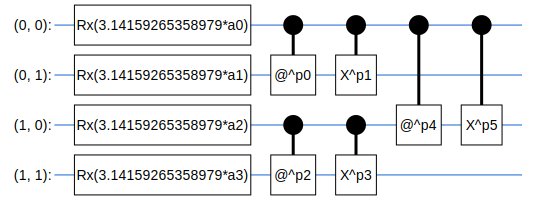

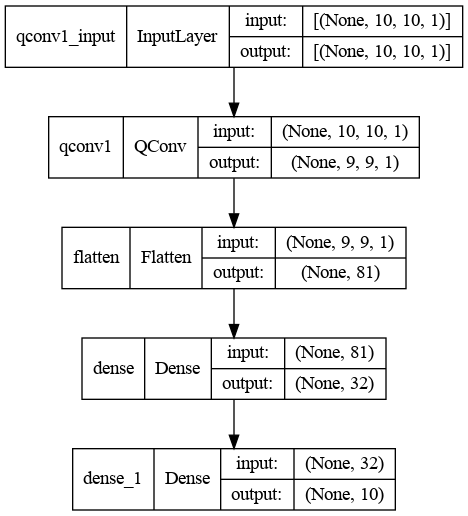

In [5]:
qcnn_model.summary()
display(SVGCircuit(QConv(filter_size=2, depth=0, activation='relu').circuit))

plot_model(qcnn_model, to_file='model_shapes.png', show_shapes=True)

In [6]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

qcnn_history = qcnn_model.fit(x_train, y_train, steps_per_epoch=500,
                        validation_data=(x_test, y_test), 
                        epochs=50, batch_size=5)

Epoch 1/50
500/500 [==============================] - 51s 99ms/step - loss: 1.6877 - accuracy: 0.5324 - val_loss: 1.0543 - val_accuracy: 0.7502
Epoch 2/50
500/500 [==============================] - 48s 96ms/step - loss: 0.8102 - accuracy: 0.7948 - val_loss: 0.6742 - val_accuracy: 0.8244
Epoch 3/50
500/500 [==============================] - 48s 96ms/step - loss: 0.6115 - accuracy: 0.8352 - val_loss: 0.5530 - val_accuracy: 0.8522
Epoch 4/50
500/500 [==============================] - 48s 97ms/step - loss: 0.5294 - accuracy: 0.8456 - val_loss: 0.4983 - val_accuracy: 0.8554
Epoch 5/50
500/500 [==============================] - 48s 97ms/step - loss: 0.5074 - accuracy: 0.8588 - val_loss: 0.4559 - val_accuracy: 0.8732
Epoch 6/50
500/500 [==============================] - 49s 98ms/step - loss: 0.4398 - accuracy: 0.8756 - val_loss: 0.4275 - val_accuracy: 0.8750
Epoch 7/50
500/500 [==============================] - 48s 96ms/step - loss: 0.4622 - accuracy: 0.8684 - val_loss: 0.4175 - val_accuracy:

In [ ]:
test_loss, test_acc = qcnn_model.evaluate(x_test, y_test, verbose=2)

313/313 - 179s - loss: 0.1522 - accuracy: 0.9532


In [ ]:
import pickle
with open('./history/default', 'wb') as file:
    pickle.dump(qcnn_history.history, file)

In [ ]:
with open('./history/default', "rb") as file:
    qcnn_history = pickle.load(file)

    fig = plt.figure()
    qcnn_loss = qcnn_history.history['val_loss']
    plt.plot(np.arange(len(qcnn_loss)) + 1, qcnn_loss, "b^-", label="QCNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 50, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Test set loss")
    plt.grid(True)
    fig.savefig('loss.png', dpi=300)


# Comparing Result

In [ ]:
def plot_loss_curves(fc_loss, cnn_loss, qcnn_loss):
    fig = plt.figure()
    plt.plot(np.arange(len(fc_loss)) + 1, fc_loss, "go-", label="fully-connected")
    plt.plot(np.arange(len(cnn_loss)) + 1, cnn_loss, "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_loss)) + 1, qcnn_loss, "b^-", label="QCNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 50, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Test set loss")
    plt.grid(True)
    fig.savefig('loss.png', dpi=300)
    
def plot_loss_curves_small(fc_loss, cnn_loss, qcnn_loss):
    fig = plt.figure()
    plt.plot(np.arange(len(fc_loss))[::2] + 1, fc_loss[::2], "go-", label="fully-connected")
    plt.plot(np.arange(len(cnn_loss))[::2] + 1, cnn_loss[::2], "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_loss))[::2] + 1, qcnn_loss[::2], "b^-", label="QCNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 50, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Test set loss")
    plt.grid(True)
    fig.savefig('loss_small.png', dpi=300)

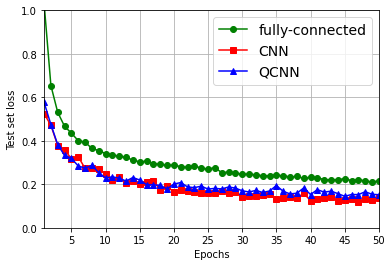

In [ ]:
plot_loss_curves(fc_history.history['val_loss'], cnn_history.history['val_loss'], qcnn_history.history['val_loss'])

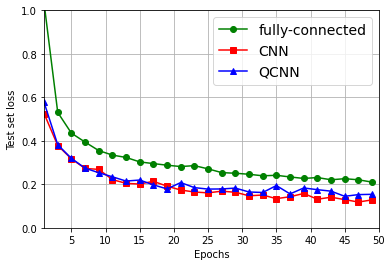

In [ ]:
plot_loss_curves_small(fc_history.history['val_loss'], cnn_history.history['val_loss'], qcnn_history.history['val_loss'])

In [ ]:
def plot_acc_curves(fc_acc, cnn_acc, qcnn_acc):
    fig = plt.figure()
    plt.plot(np.arange(len(fc_acc)) + 1, fc_acc, "go-", label="fully-connected")
    plt.plot(np.arange(len(cnn_acc)) + 1, cnn_acc, "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_acc)) + 1, qcnn_acc, "b^-", label="QCNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.grid()
    plt.axis([1, 50, 0.8, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Test set accuracy")
    fig.savefig('accuracy.png', dpi=300)
    
def plot_acc_curves_small(fc_acc, cnn_acc, qcnn_acc):
    fig = plt.figure()
    plt.plot(np.arange(len(fc_acc))[::2] + 1, fc_acc[::2], "go-", label="fully-connected")
    plt.plot(np.arange(len(cnn_acc))[::2] + 1, cnn_acc[::2], "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_acc))[::2] + 1, qcnn_acc[::2], "b^-", label="QCNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.grid()
    plt.axis([1, 50, 0.8, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Test set accuracy")
    fig.savefig('accuracy_small.png', dpi=300)

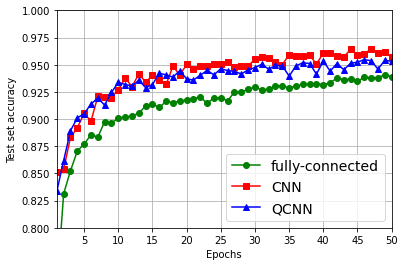

In [ ]:
plot_acc_curves(fc_history.history['val_accuracy'], cnn_history.history['val_accuracy'], qcnn_history.history['val_accuracy'])

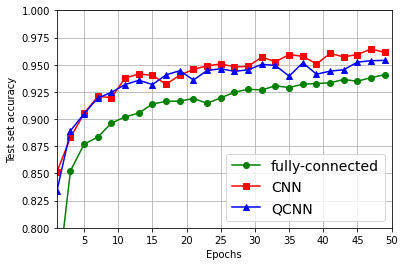

In [ ]:
plot_acc_curves_small(fc_history.history['val_accuracy'], cnn_history.history['val_accuracy'], qcnn_history.history['val_accuracy'])